# Image-to-sketch Style Transfer 



In [1]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import cv2
# to read an image from a url
from imageio import imread

# for number-crunching
import numpy as np

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

<ipython-input-1-32f217b9b241>:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import AlexNet and freeze all layers

In [3]:
# import the model
vggnet = torchvision.models.vgg19(pretrained=True)

# freeze all layers
for p in vggnet.parameters():
    p.requires_grad = False
  
# set to evaluation mode
vggnet.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 198MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [4]:
# send the network to the GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

vggnet.to(device);

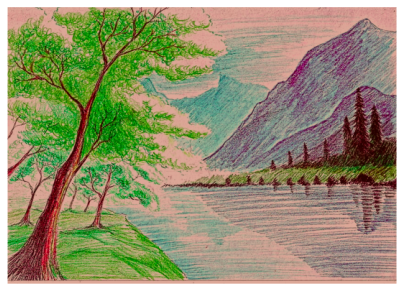

In [5]:
def show_(img, name):
    # convert colorcode for matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig=plt.figure(figsize=(9, 5))
    plt.axis('off')
    plt.gca().set_title(name)
    plt.imshow(img)

"""
Based on the fact that visual perceptors are more sensitive on changes in luminosity than in colour.
From content and style image we extract luminosity characteristics.

In most cases, computationally less expensive than color histogram matching.
If the process of histogram matching is more complicated it can be less effective than color histogram matching.
"""

import numpy as np
import cv2


def mean_std_dev(image):
    mean = [
        np.mean(image[:, :, 0]),
        np.mean(image[:, :, 1]),
        np.mean(image[:, :, 2])
    ]
    std_dev = [
        np.std(image[:, :, 0]),
        np.std(image[:, :, 1]),
        np.std(image[:, :, 2])
    ]

    return mean, std_dev

CONTENT_IMAGE_NAME = "/content/drive/MyDrive/Sketchtoimage/Peripitus - Lotus.jpg"

STYLE_IMAGE_NAME =  "/content/drive/MyDrive/Sketchtoimage/style3.jpeg"

LOGARITHMIC_COLOR_SPACE = cv2.COLOR_BGR2LAB
RGB_COLOR_SPACE = cv2.COLOR_LAB2BGR


class LuminanceOnlyTransfer(object):
    def __init__(self):
        print("LuminanceOnlyTransfer initialized.")

    @staticmethod
    def open_image_in_log_space(image_path):
        image = cv2.imread(image_path)    
        kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
        imgage = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
        image = cv2.detailEnhance(image, sigma_s=10, sigma_r=0.15)
        image = cv2.cvtColor(image, LOGARITHMIC_COLOR_SPACE)
        return image

    @staticmethod
    def match(style_image_path, content_image_path):
        style_image = LuminanceOnlyTransfer.open_image_in_log_space(style_image_path)
        s_height, s_width, s_depth = style_image.shape
        content_image = LuminanceOnlyTransfer.open_image_in_log_space(content_image_path)

        mu_s, sigma_s = mean_std_dev(style_image)
        mu_c, sigma_c = mean_std_dev(content_image)

        for h in range(0, s_height):
            for w in range(0, s_width):
                for d in range(0, s_depth):
                    """
                    Each luminance pixel is updated with formula:
                    Ls' = (sigma_c / sigma_s) * (Ls - mu_s) + mu_c
                    """
                    luminance_pixel = style_image[h, w, d]
                    luminance_pixel = (sigma_c[d] / sigma_s[d]) * \
                                      (luminance_pixel - mu_s[d]) + mu_c[d]

                    if luminance_pixel < 0:
                        luminance_pixel = 0
                    if luminance_pixel > 255:
                        luminance_pixel = 255

                    style_image[h, w, d] = luminance_pixel

        style_image = cv2.cvtColor(style_image, RGB_COLOR_SPACE)
        #cv2.imwrite('/lumiance.jpg', style_image)

        return style_image

style_img = LuminanceOnlyTransfer.match(STYLE_IMAGE_NAME, CONTENT_IMAGE_NAME)
show_(style_img, '')

In [6]:
img = cv2.imread(CONTENT_IMAGE_NAME)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Import two images

In [7]:
import imageio.v2
import cv2

img4content = img
img4style   = cv2.cvtColor(style_img, cv2.COLOR_BGR2RGB)

def change_dim(img):
  if len(img.shape) > 2 and img.shape[2] == 4:
      #convert the image from RGBA2RGB
      img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
  return img

img4content  = change_dim(img4content)
img4style = change_dim(img4style)

# initialize the target image and random numbers
img4target = np.random.randint(low=0,high=255,size=img4content.shape,dtype=np.uint8)
# In case of grayScale images the len(img.shape) == 2

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

(586, 800, 3)
(586, 800, 3)
(604, 850, 3)


In [8]:
## These images are really large, which will make training take a long time. 

# create the transforms
Ts = T.Compose([ T.ToTensor(),
                 T.Resize(256),
                 T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
               ])

# apply them to the images ("unsqueeze" to make them a 4D tensor) and push to GPU
img4content = Ts( img4content ).unsqueeze(0).to(device)
img4style   = Ts( img4style ).unsqueeze(0).to(device)
img4target  = Ts( img4target ).unsqueeze(0).to(device)

print(img4content.shape)
print(img4target.shape)
print(img4style.shape)

torch.Size([1, 3, 256, 349])
torch.Size([1, 3, 256, 349])
torch.Size([1, 3, 256, 360])


/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


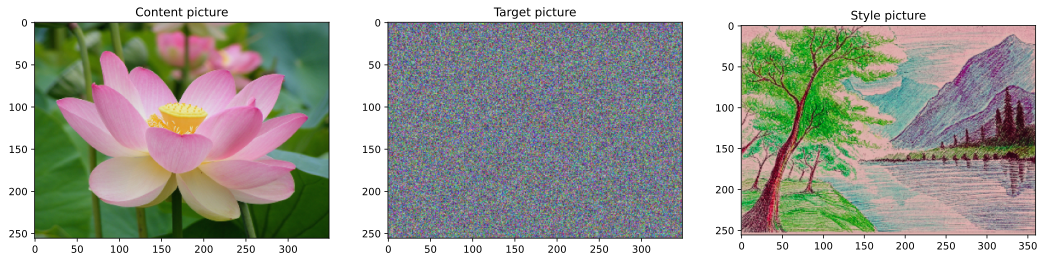

In [9]:
# Let's have a look at the "before" pics
fig,ax = plt.subplots(1,3,figsize=(18,6))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture')

pic = img4target.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[1].imshow(pic)
ax[1].set_title('Target picture')

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic)
ax[2].set_title('Style picture')

plt.show()

# Functions to extract image feature map activations

In [10]:
# A function that returns feature maps

def getFeatureMapActs(img,net):
  
  # initialize feature maps as a list
  featuremaps = []
  featurenames = []

  convLayerIdx = 0

  # loop through all layers in the "features" block
  for layernum in range(len(net.features)):
    
    # print out info from this layer
    # print(layernum,net.features[layernum])

    # process the image through this layer
    img = net.features[layernum](img)

    # store the image if it's a conv2d layer
    if 'Conv2d' in str(net.features[layernum]):
      featuremaps.append( img )
      featurenames.append( 'ConvLayer_' + str(convLayerIdx) )
      convLayerIdx += 1
  
  return featuremaps,featurenames

In [11]:
# A function that returns the Gram matrix of the feature activation map

def gram_matrix(F):
  
  # reshape to 2D
  _,chans,height,width = F.shape
  F = F.reshape(chans,height*width)  

  # compute and return covariance matrix
  gram = torch.mm(F,F.t()) / (chans*height*width)
  return gram

In [12]:
# inspect the output of the function
featmaps,featnames = getFeatureMapActs(img4content,vggnet)

# print out some info
for i in range(len(featnames)):
  print('Feature map "%s" is size %s'%(featnames[i],(featmaps[i].shape)))

Feature map "ConvLayer_0" is size torch.Size([1, 64, 256, 349])
Feature map "ConvLayer_1" is size torch.Size([1, 64, 256, 349])
Feature map "ConvLayer_2" is size torch.Size([1, 128, 128, 174])
Feature map "ConvLayer_3" is size torch.Size([1, 128, 128, 174])
Feature map "ConvLayer_4" is size torch.Size([1, 256, 64, 87])
Feature map "ConvLayer_5" is size torch.Size([1, 256, 64, 87])
Feature map "ConvLayer_6" is size torch.Size([1, 256, 64, 87])
Feature map "ConvLayer_7" is size torch.Size([1, 256, 64, 87])
Feature map "ConvLayer_8" is size torch.Size([1, 512, 32, 43])
Feature map "ConvLayer_9" is size torch.Size([1, 512, 32, 43])
Feature map "ConvLayer_10" is size torch.Size([1, 512, 32, 43])
Feature map "ConvLayer_11" is size torch.Size([1, 512, 32, 43])
Feature map "ConvLayer_12" is size torch.Size([1, 512, 16, 21])
Feature map "ConvLayer_13" is size torch.Size([1, 512, 16, 21])
Feature map "ConvLayer_14" is size torch.Size([1, 512, 16, 21])
Feature map "ConvLayer_15" is size torch.Siz

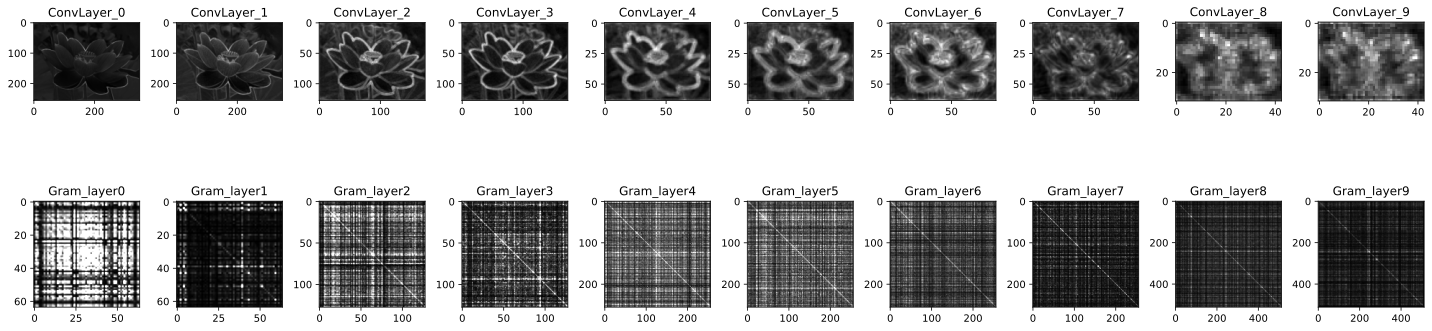

In [21]:

# let's see what the "content" image looks like
contentFeatureMaps,contentFeatureNames = getFeatureMapActs(img4content,vggnet)


fig,axs = plt.subplots(2,10,figsize=(20,6))
for i in range(10):

  # average over all feature maps from this layer, and normalize
  pic = np.mean( contentFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='gray')
  axs[0,i].set_title( str(contentFeatureNames[i]))


  ### now show the gram matrix
  pic = gram_matrix(contentFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='gray',vmax=.1)
  axs[1,i].set_title("Gram_layer"+str(i))

plt.tight_layout()
plt.show()

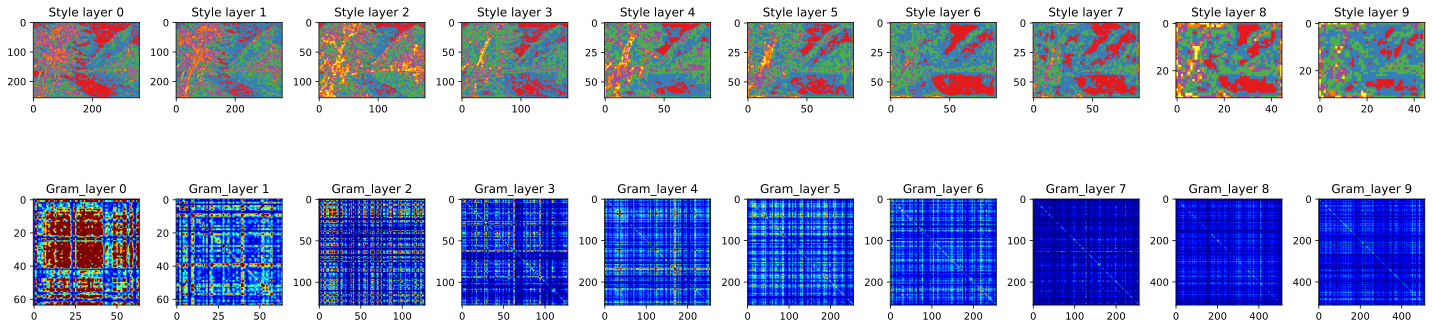

In [22]:

# repeat for the "style" image
styleFeatureMaps,styleFeatureNames = getFeatureMapActs(img4style,vggnet)


fig,axs = plt.subplots(2,10,figsize=(20,6))
for i in range(10):

  # average over all feature maps from this layer, and normalize
  pic = np.mean( styleFeatureMaps[i].cpu().squeeze().numpy() ,axis=0)
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[0,i].imshow(pic,cmap='Set1')
  axs[0,i].set_title('Style layer ' + str(i))


  ### now show the gram matrix
  pic = gram_matrix(styleFeatureMaps[i]).cpu().numpy()
  pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))

  axs[1,i].imshow(pic,cmap='jet',vmax=.1)
  axs[1,i].set_title('Gram_layer ' + str(i))

plt.tight_layout()
plt.show()

# Now for the transfer

In [15]:
# which layers to use
#styleScaling = 5e4
layers4content = [ 'ConvLayer_8']
layers4style   = [ 'ConvLayer_0','ConvLayer_1','ConvLayer_2','ConvLayer_3','ConvLayer_4', 'ConvLayer_5', 'ConvLayer_6' ]
# decreasing weight for lower layers >> focus more on the small details of the style image rather than large-scale general stylr
weights4style  = [    1  ,      0.9    ,    0.8     ,   0.6  ,     0.5   ,   0.3   ,   0.1   ]


In [16]:
# make a copy of the target image and push to GPU
target = img4content.clone()
target.requires_grad = True
target = target.to(device)
styleScaling = 5e4

# number of epochs to train
numepochs = 1500

# optimizer for backprop
optimizer = torch.optim.RMSprop([target],lr=.001)


for epochi in range(numepochs):

  # extract the target feature maps
  targetFeatureMaps,targetFeatureNames = getFeatureMapActs(target,vggnet)


  # initialize the individual loss components
  styleLoss = 0
  contentLoss = 0

  # loop over layers
  for layeri in range(len(targetFeatureNames)):


    # compute the content loss
    if targetFeatureNames[layeri] in layers4content:
      contentLoss += torch.mean( (targetFeatureMaps[layeri]-contentFeatureMaps[layeri])**2 )


    # compute the style loss
    if targetFeatureNames[layeri] in layers4style:
      
      # Gram matrices
      Gtarget = gram_matrix(targetFeatureMaps[layeri])
      Gstyle  = gram_matrix(styleFeatureMaps[layeri])

      # compute their loss
      styleLoss += torch.mean( (Gtarget-Gstyle)**2 ) * weights4style[layers4style.index(targetFeatureNames[layeri])]

  
  # combined loss
  combiloss = styleScaling*styleLoss + contentLoss

  # finally ready for backprop!
  optimizer.zero_grad()
  combiloss.backward()
  optimizer.step()


# Let's have a looksie!

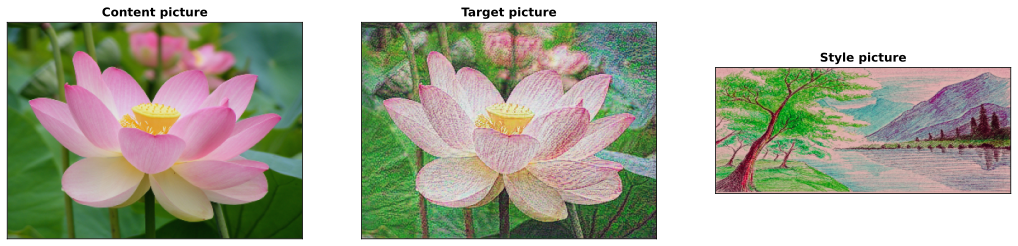

In [17]:
# the "after" pic
fig,ax = plt.subplots(1,3,figsize=(18,11))

pic = img4content.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[0].imshow(pic)
ax[0].set_title('Content picture',fontweight='bold')
ax[0].set_xticks([])
ax[0].set_yticks([])

pic = torch.sigmoid(target).cpu().detach().squeeze().numpy().transpose((1,2,0))
plt.savefig('/content/drive/MyDrive/Sketchtoimage/res.png')
ax[1].imshow(pic)
ax[1].set_title('Target picture',fontweight='bold')
ax[1].set_xticks([])
ax[1].set_yticks([])

pic = img4style.cpu().squeeze().numpy().transpose((1,2,0))
pic = (pic-np.min(pic)) / (np.max(pic)-np.min(pic))
ax[2].imshow(pic,aspect=.6)
ax[2].set_title('Style picture',fontweight='bold')
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()